Load the data

In [1]:
import pandas as pd
#import matplotlib.pyplot as plt

#%matplotlib inline

path = r"C:\Users\Surface\Masterarbeit\data\Baseline.xlsx"

df = pd.read_excel(path)


Transformation Pipeline

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# get the numerical features
data_num = df.drop('x_Einzug [mm]', axis = 1)
# get the target values
data_labels = df['x_Einzug [mm]'].to_numpy()

# pipeline for preprocessing the data

# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

data_prep = data_pipeline.fit_transform(data_num)

X_temp, X_test, y_temp, y_test = train_test_split(data_prep, data_labels, test_size= 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size= 0.25, random_state=42)
print(data_prep.shape, X_train.shape, X_val.shape, X_test.shape)

(729, 6) (437, 6) (146, 6) (146, 6)


Gradient Boosting Trees: Decision trees die Fehler korrigieren, Model besteht aus der Summer der einzelenen Modele

In [ ]:
import xgboost
from sklearn.metrics import r2_score

# Initialize the XGBoost regressor
xgb_reg = xgboost.XGBRegressor()

# Fit the model to the training data
xgb_reg.fit(X_train, y_train)

#Get feature importances from the trained model
importances = xgb_reg.feature_importances_
features = ['Matrizenradius [mm ]', 'Stempelkantenradius [mm]', 'Blechdicke [mm]',
            'Platinenabmessung [mm]', '1/4 Niederhalterkraft [N]', 'Ziehtiefe [mm]']

# Create a DataFrame to display feature importance, sorted descending
xgb_feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#show important features
display(xgb_feat_df)

#Make predictions on train and test set
y_train_pred = xgb_reg.predict(X_train)
y_test_pred = xgb_reg.predict(X_test)

#Calculate R² scores for train and test predictions
r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

#Compare R2 Score for the first 10 instances
vergleich_df = pd.DataFrame({
    'True value' : y_test[:10],
    'Prediction' : y_test_pred[:10].flatten(),
    'Difference' : y_test[:10] - y_test_pred[:10].flatten()
 })

#print the result
print(f'\nR² Train: {r2_train:.4f} | R² Test: {r2_test:.4f}')
display(vergleich_df.style.background_gradient(cmap='RdYlGn_r'))

,Feature,Importance
5,Ziehtiefe [mm],0.745549
1,Stempelkantenradius [mm],0.125797
3,Platinenabmessung [mm],0.123737
4,1/4 Niederhalterkraft [N],0.002886
0,Matrizenradius [mm ],0.001195
2,Blechdicke [mm],0.000837



R² Train: 1.0000 | R² Test: 0.9997


,True value,Prediction,Difference
0,6.590000,6.567898,0.022102
1,8.100000,8.085225,0.014775
2,9.231000,9.233231,-0.002231
3,7.623000,7.621459,0.001541
4,9.253500,9.222149,0.031351
5,10.484500,10.444893,0.039607
6,8.219000,8.217233,0.001767
7,6.679500,6.685080,-0.005580
8,8.614500,8.610810,0.003690
9,7.534500,7.529448,0.005052


NGBoost for outputting Probalitiy Distribution instead of single value https://stanfordmlgroup.github.io/ngboost/1-useage.html

[iter 0] loss=1.5186 val_loss=1.4922 scale=1.0000 norm=1.0769
[iter 100] loss=0.7495 val_loss=0.7619 scale=2.0000 norm=1.1187
[iter 200] loss=-0.1461 val_loss=-0.1234 scale=2.0000 norm=0.9154
[iter 300] loss=-1.0106 val_loss=-0.9598 scale=2.0000 norm=0.8707
R² on Test Data: 0.999
R² on Test Data: 0.999
Coverage: 100.00%


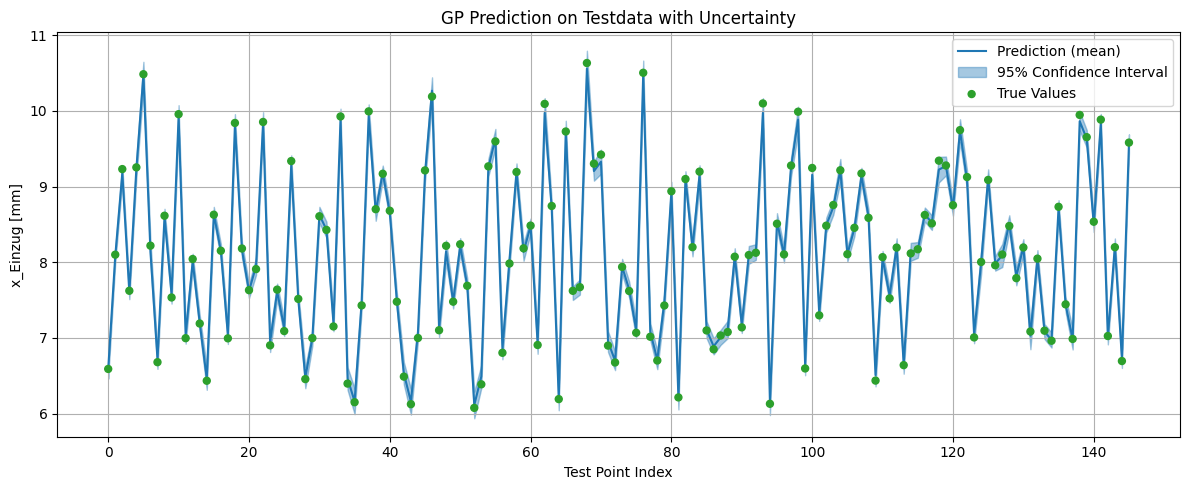

In [28]:
from ngboost import NGBRegressor
from ngboost.scores import LogScore
from ngboost.distns import  Normal
import numpy as np
import matplotlib.pyplot as plt

# first choice: normal distribution
# default base learner is a depth 3 decision tree
ngb = NGBRegressor(Dist=Normal, Score = LogScore, verbose = True, n_estimators=400, learning_rate=0.01)
# fit the model to the training data, early stopping on validation set after 2 rounds without improvement
ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=2)

# Predicte distribution for train and test data
y_dists_train = ngb.pred_dist(X_train)
y_dists_test = ngb.pred_dist(X_test)

# Extract mean and standard deviation from predictions
train_mean = y_dists_train.loc
train_stddev = y_dists_train.scale

# Calculate R² for the train data
r2_test = r2_score(y_train, train_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# Extract mean and standard deviation from predictions
test_mean = y_dists_test.loc
test_stddev = y_dists_test.scale
true = y_test

# Calculate R² for the test data
r2_test = r2_score(true, test_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
ngboost_lower = test_mean - 2*test_stddev
ngboost_upper = test_mean + 2*test_stddev

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (true >= ngboost_lower) & (true <= ngboost_upper)
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval]

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Plotting the prediction with uncertainty and true values
plt.figure(figsize=(12, 5))
x_axis = np.arange(len(y_test))

# Plot predicted mean
plt.plot(x_axis, test_mean, label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, ngboost_lower, ngboost_upper,
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, true, label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("GP Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()